In [1]:
import numpy as np
from scipy.io import loadmat
import scipy
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from decimal import Decimal
import time
import matplotlib.pyplot as plt
import random

# Image reconstruction in X-ray tomography

$\underline{\textbf{Q1.}}$ We start by loading the matrix $H$ and the image matrix $\bar{x}$

In [2]:
x = loadmat("data/x.mat")['x']
H = loadmat("data/H.mat")['H']
G = loadmat("data/H.mat")['H']

Let's visualize the image $\bar{x}$

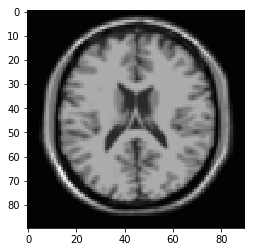

In [3]:
plt.imshow(x.reshape(90,90).T,cmap = 'gray')

In [4]:
M = H.shape[0]
N = x.shape[0]

sigma = 1
lamb = 0.13
delta = 0.02

w = np.random.normal(scale = sigma, size=(M,1))
y = H*x+w

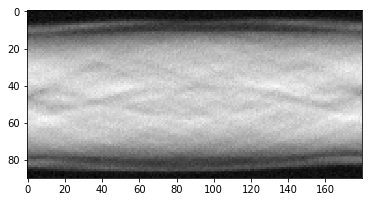

In [5]:
plt.imshow(y.reshape(180,90).T,cmap = 'gray')

In [6]:
def grad_f(x,y,G,H,lamb,delta):
    return H.T*(H*x - y) + lamb * r_prime(x,delta,G)

def psi_prime(u,delta):
    return u/(delta**2 * psi(u,delta))

def psi(u,delta):
    return np.sqrt(1+np.power(u,2)/delta**2)

def psi_second(u,delta):
    return 1/(delta**2 * psi(u,delta))

def f(x,y,G,H,lamb,delta):
    return 0.5*np.linalg.norm(H*x - y)**2 + lamb*r(x,delta,G) 

def A(x,G,HH,lamb,delta):  
    return scipy.sparse.csr_matrix.todense(H.T*H + lamb/2*G.T*scipy.sparse.spdiags(np.squeeze(psi_second(G*x,delta)),0,M,M)*G) # To compute
    #return HH + lamb/2*(G.T*scipy.sparse.spdiags(np.squeeze(psi_second(G*x,delta)),0,M,M))*G # To compute
    
def r(x,delta,G):
    return float(np.sum(psi(G*x,delta),axis=0))

def r_prime(x,delta,G):
    return G.T*psi_prime(G*x,delta)

def SNR(x_hat,x):
    return 10 * np.log10(np.linalg.norm(x)**2/np.linalg.norm(x-x_hat)**2)

x0 = np.zeros((N,1))
HH = H.T*H
L = scipy.sparse.linalg.norm(H)**2 + delta/lamb**2 * scipy.sparse.linalg.norm(G)**2

In [68]:
#A(x,G,H,lamb,delta)
 H.T*H

<8100x8100 sparse matrix of type '<class 'numpy.float64'>'
	with 65435454 stored elements in Compressed Sparse Row format>

Iteration 0, objective: 6.73E+6, 449748.2330718242
Iteration 100, objective: 1.50E+6, 182150.5260140208
Iteration 200, objective: 5.86E+5, 79057.60067788225
Iteration 300, objective: 3.96E+5, 39922.77798487786
Iteration 400, objective: 3.37E+5, 25759.901863565217
Iteration 500, objective: 3.08E+5, 19932.693621201157
Iteration 600, objective: 2.89E+5, 16601.188882498594
Iteration 700, objective: 2.75E+5, 14192.308759543223
Iteration 800, objective: 2.65E+5, 12291.247776911094
Iteration 900, objective: 2.57E+5, 10749.12257529567
Iteration 1000, objective: 2.51E+5, 9484.297986176316

Signal to Noise Ratio: 10.131536182066894


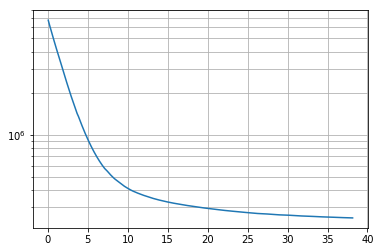

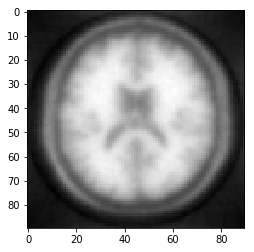

In [41]:
def gradient_descent(f,grad_f,x0,L,N,y,G,H,lamb,delta):
    gamma = 1/L
    grad = N*1e-4
    x = x0
    it = 0
    itermax = 1000 #5000
    objectives = []
    times = [0]
    
    while grad > np.sqrt(N)*1e-4 and it <= itermax: 
        
        t1 = time.time()
        gradient = grad_f(x,y,G,H,lamb,delta)
        x = x - gamma*gradient
        grad = np.linalg.norm(gradient)
        criterion = f(x,y,G,H,lamb,delta)        
        objectives.append(criterion)
        
        if it%100 == 0:
            print("Iteration {}, objective: {:.2E}, {}".format(it,Decimal(criterion),grad))          
        t2 = time.time()
        times.append(times[-1]+t2-t1)
        it += 1
    return x,objectives,times
        
x_hat,objectives,times = gradient_descent(f,grad_f,x0,L,N,y,G,H,0.01,delta)
plt.figure()
plt.semilogy(times[1:],objectives)
plt.grid(which='both')
print('\nSignal to Noise Ratio:',SNR(x_hat,x))
plt.figure()
plt.imshow(x_hat.reshape(90,90).T,cmap = 'gray')

Iteration 0, objective: 6.81E+6, 449618.18369335186, 6803835.780133601
Iteration 1, objective: 6.67E+6, 358266.35864099977, 6627059.983263236
Iteration 2, objective: 6.04E+6, 350001.5883367958, 5853604.735059994
Iteration 3, objective: 4.60E+6, 323624.717165757, 4009426.5802004444
Iteration 4, objective: 3.36E+6, 252647.5445625119, 2266016.7784822853
Iteration 5, objective: 2.77E+6, 166472.4455366047, 1302117.109450389
Iteration 6, objective: 2.55E+6, 102208.90177149097, 833052.2547347659
Iteration 7, objective: 2.47E+6, 61488.006247923106, 601053.8863949922
Iteration 8, objective: 2.44E+6, 37021.13691138189, 480090.83751820034
Iteration 9, objective: 2.43E+6, 22578.188273053882, 413541.69375869527
Iteration 10, objective: 2.42E+6, 14067.125989207012, 375249.1731616043

Signal to Noise Ratio: -22.665903004460418


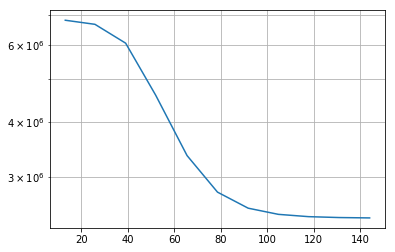

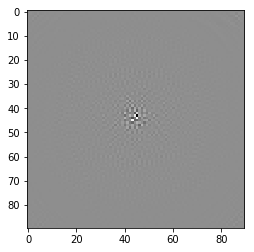

In [11]:
def MM_quadratic(f,grad_f,invA,x0,L,N,y,G,H,lamb,delta,HH):
    grad = N*1e-4
    x = x0
    it = 0
    itermax = 10
    objectives = []
    times = [0]
    
    while grad > np.sqrt(N)*1e-4 and it <= itermax:         
        t1 = time.time()
        gradient = grad_f(x,y,G,H,lamb,delta)
        #x = x - 1.99*np.dot(invA,gradient)
        #x = x - 1*scipy.sparse.linalg.bicg(A(x,y,G,H,lamb,delta),gradient)
        x = x - 0.5*np.linalg.solve(A(x,G,HH,lamb,delta),gradient)
        #x = x - 1.99*np.linalg.lstsq(A(x,y,G,H,lamb,delta),gradient,rcond=None)
        grad = np.linalg.norm(gradient)
        criterion = f(x,y,G,H,lamb,delta)        
        objectives.append(criterion)
        
        if it%1 == 0:
            print("Iteration {}, objective: {:.2E}, {}, {}".format(it,Decimal(criterion),grad,0.5*np.linalg.norm(H*x - y)**2))        
        t2 = time.time()
        times.append(times[-1]+t2-t1)
        it += 1
    return x,objectives,times
        
x_hat,objectives,times = MM_quadratic(f,grad_f,A,x0,L,N,y,G,H,lamb,delta,HH)
plt.figure()
plt.semilogy(times[1:],objectives)
plt.grid(which='both')
print('\nSignal to Noise Ratio:',SNR(x_hat,x))
plt.figure()
plt.imshow(x_hat.reshape(90,90).T,cmap = 'gray')

Iteration 0, objective: 6.78E+6, 449618.18369335186
Iteration 1, objective: 6.35E+6, 350720.62582019035
Iteration 2, objective: 4.44E+6, 330829.9565726631
Iteration 3, objective: 2.59E+6, 227467.86548808098
Iteration 4, objective: 2.46E+6, 63203.30480287073
Iteration 5, objective: 2.45E+6, 13991.047521255538
Iteration 6, objective: 2.44E+6, 10708.91657605372
Iteration 7, objective: 2.44E+6, 9133.783766990424
Iteration 8, objective: 2.43E+6, 8802.218512901522
Iteration 9, objective: 2.43E+6, 9756.610250663853
Iteration 10, objective: 2.43E+6, 5864.942929006111

Signal to Noise Ratio: 9.964377881730911


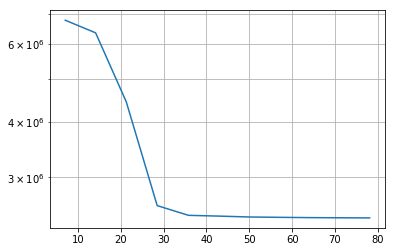

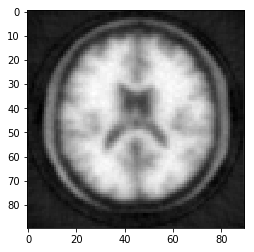

In [10]:
def MMMG(f,grad_f,A,x0,L,N,y,G,H,lamb,delta,HH):
    gamma = 1/L
    grad = N*1e-4
    x = x0
    it = 0
    itermax = 10
    #criterion = f(x,y,G,H,lamb,delta)
    #print("Iteration 0, objective: {:.2E}".format(Decimal(criterion)))
    objectives = []
    times = [0]
    
    while grad > np.sqrt(N)*1e-4 and it <= itermax: 
        t1 = time.time()
        gradient = grad_f(x,y,G,H,lamb,delta)
        if it == 0:
            D = - gradient
        else:
            D = np.concatenate((-gradient,diff),axis=1)
        
        #print(D,x.shape)
        temp = np.dot(np.dot(D.T,A(x,G,HH,lamb,delta)),D)
        u = - np.dot(np.linalg.pinv(temp),np.dot(D.T,gradient))
        x = x + np.dot(D,u)
        grad = np.linalg.norm(gradient)
        criterion = f(x,y,G,H,lamb,delta)        
        objectives.append(criterion)
        
        if it%1 == 0:
            print("Iteration {}, objective: {:.2E}, {}".format(it,Decimal(criterion),grad))        
        t2 = time.time()
        times.append(times[-1]+t2-t1)
        diff = np.dot(D,u)
        it += 1
    return x,objectives,times
        
x_hat,objectives,times = MMMG(f,grad_f,A,x0,L,N,y,G,H,lamb,delta,HH)
plt.figure()
plt.semilogy(times[1:],objectives)
plt.grid(which='both')
print('\nSignal to Noise Ratio:',SNR(x_hat,x))
plt.figure()
plt.imshow(x_hat.reshape(90,90).T,cmap = 'gray')

In [ ]:
def MM_block(f,grad_f,invA,x0,L,N,y,G,H,lamb,delta,J,Nj):
    grad = N*1e-4
    x = x0
    it = 0
    itermax = 10
    objectives = []
    times = [0]
    
    while grad > np.sqrt(N)*1e-4 and it <= itermax:   
        j = it%J + 1
        
        t1 = time.time()
        gradient = grad_f(x,y,G,H,lamb,delta)[Nj*(j-1):J*Nj+1]
        
        #x = x - 1.99*np.dot(invA,gradient)
        #x = x - 1*scipy.sparse.linalg.bicg(A(x,y,G,H,lamb,delta),gradient)
        x[Nj*(j-1):J*Nj+1] = x[Nj*(j-1):J*Nj+1] - 1.99*np.linalg.solve(A(x,G,H,lamb,delta)[Nj*(j-1):J*Nj+1,Nj*(j-1):J*Nj+1],gradient)
        #x = x - 1.99*np.linalg.lstsq(A(x,y,G,H,lamb,delta),gradient,rcond=None)
        
        grad = np.linalg.norm(gradient)
        criterion = f(x,y,G,H,lamb,delta)        
        objectives.append(criterion)
        
        if it%1 == 0:
            print("Iteration {}, objective: {:.2E}, {}, {}".format(it,Decimal(criterion),grad,0.5*np.linalg.norm(H*x - y)**2))        
        t2 = time.time()
        times.append(times[-1]+t2-t1)
        it += 1
    return x,objectives,times
        
x_hat,objectives,times = MM_block(f,grad_f,A,x0,L,N,y,G,H,lamb,delta,2,N//2)
plt.figure()
plt.semilogy(times[1:],objectives)
plt.grid(which='both')
print('\nSignal to Noise Ratio:',SNR(x_hat,x))
plt.figure()
plt.imshow(x_hat.reshape(90,90).T,cmap = 'gray')

Iteration 0, objective: 6.71E+6, 449618.18369335186, 6680091.526236122
Iteration 1, objective: 5.39E+6, 248525.9966808067, 5009256.772400525
Iteration 2, objective: 3.07E+6, 290187.2633664276, 950348.530202298
Iteration 3, objective: 2.98E+6, 56214.13814612444, 1444113.594255363
Iteration 4, objective: 2.63E+6, 103942.05930918461, 205617.35245496666


In [ ]:
def MM_parallel(f,grad_f,invA,x0,L,N,y,G,H,lamb,delta):
    grad = N*1e-4
    x = x0
    it = 0
    itermax = 10
    objectives = []
    times = [0]
    
    while grad > np.sqrt(N)*1e-4 and it <= itermax:   
        j = it%J + 1
        
        t1 = time.time()
        gradient = grad_f(x,y,G,H,lamb,delta)[Nj*(j-1):J*Nj+1]
        
        #x = x - 1.99*np.dot(invA,gradient)
        #x = x - 1*scipy.sparse.linalg.bicg(A(x,y,G,H,lamb,delta),gradient)
        x[Nj*(j-1):J*Nj+1] = x[Nj*(j-1):J*Nj+1] - 1.99*np.linalg.solve(A(x,G,H,lamb,delta)[Nj*(j-1):J*Nj+1,Nj*(j-1):J*Nj+1],gradient)
        #x = x - 1.99*np.linalg.lstsq(A(x,y,G,H,lamb,delta),gradient,rcond=None)
        grad = np.linalg.norm(gradient)
        criterion = f(x,y,G,H,lamb,delta)        
        objectives.append(criterion)
        
        if it%1 == 0:
            print("Iteration {}, objective: {:.2E}, {}, {}".format(it,Decimal(criterion),grad,0.5*np.linalg.norm(H*x - y)**2))        
        t2 = time.time()
        times.append(times[-1]+t2-t1)
        it += 1
    return x,objectives,times
        
x_hat,objectives,times = MM_parallel(f,grad_f,A,x0,L,N,y,G,H,lamb,delta)
plt.figure()
plt.semilogy(times[1:],objectives)
plt.grid(which='both')
print('\nSignal to Noise Ratio:',SNR(x_hat,x))
plt.figure()
plt.imshow(x_hat.reshape(90,90).T,cmap = 'gray')